# Lesson 6 - Starter code for guided practice & demos

In [1]:
# Imports
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from sklearn import cross_validation, linear_model, metrics
%matplotlib inline

# Config
sns.set_style("darkgrid")
DATA_DIR = Path('./resources/')
np.random.seed(1)

## Slide: "Let's compare two random models"

   x  y
0  0  0
1  1  1
2  2  2
3  3  3
4  4  4

   x  y
0  1  1
1  1  1
2  1  1
3  1  1
4  1  1


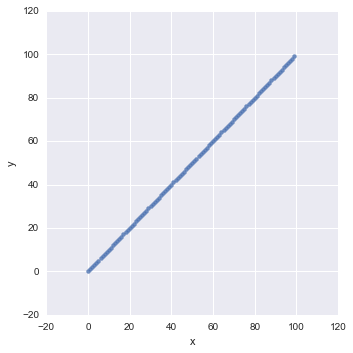

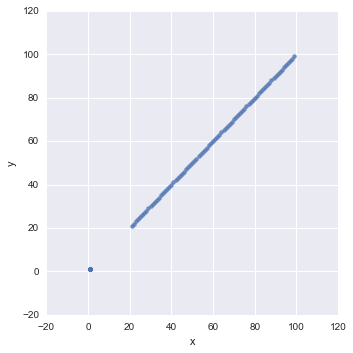

In [2]:
# Create two dfs of data
df = pd.DataFrame({'x': range(100), 'y': range(100)})
biased_df = df.copy()
biased_df.loc[:20, 'x'] = 1
biased_df.loc[:20, 'y'] = 1

# What do these look like?
print df.head()
print
print biased_df.head()
print sns.lmplot('x', 'y', df, fit_reg=False)
print sns.lmplot('x', 'y', biased_df, fit_reg=False)

          x          y
0  4.170220   3.266449
1  8.203245   6.270581
2  2.001144  10.859421
3  6.023326   6.572698
4  5.467559  13.085352

           x         y
0  10.501761  9.118587
1   6.566532  9.749616
2  10.156063  7.884133
3   7.415662  6.694944
4   4.900077  2.609714


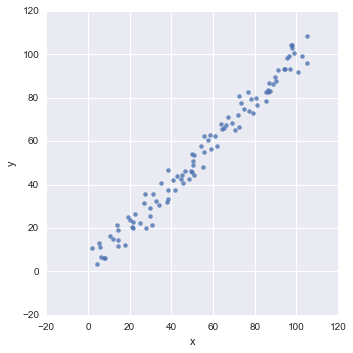

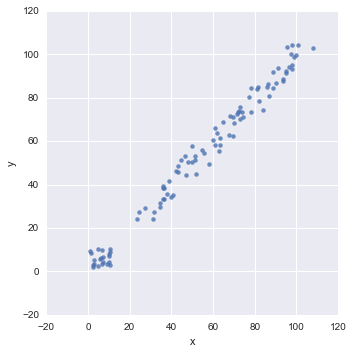

In [3]:
# Now "jitter" them by adding some random variates
def append_jitter(series):
    jitter = 10 * np.random.random_sample(size=100)
    return series + jitter

df['x'] = append_jitter(df.x)
df['y'] = append_jitter(df.y)

biased_df['x'] = append_jitter(biased_df.x)
biased_df['y'] = append_jitter(biased_df.y)

print df.head()
print
print biased_df.head()
print sns.lmplot('x', 'y', df, fit_reg=False)
print sns.lmplot('x', 'y', biased_df, fit_reg=False)

In [4]:
## Fit a LinearRegression to each
lm = linear_model.LinearRegression().fit(df[['x']], df['y'])
biased_lm = linear_model.LinearRegression().fit(biased_df[['x']], biased_df['y'])

In [5]:
# Evaluate MSE for unbiased model (trained on unbiased data) against the unbiased data
print metrics.mean_squared_error(df['y'], lm.predict(df[['x']]))

# Evaluate the MSE for biased model (trained on biased data) against the BIASED data
print metrics.mean_squared_error(biased_df['y'], biased_lm.predict(biased_df[['x']]))

# Evaluate the MSE for biased model (trained on biased data) against the UNBIASED data
print metrics.mean_squared_error(df['y'], biased_lm.predict(df[['x']]))

# If model (or dataset on which it was trained) has a lot of bias, it may have low MSE
# or good R^2 on its own dataset, but won't generalise as well to new data. We'd therefore
# like to find a way to prevent against this bias (this will unfortunately increase variance,
# i.e. R^2 will decrease & MSE will increase for the unbiased model vs unbiased data).

18.5449061202
16.6440233816
19.027066123


## Slide: "Using k-fold cross-validation with MSE"

In [6]:
# Read in bikeshare data
bikeshare = pd.read_csv(DATA_DIR / 'bikeshare.csv')
bikeshare.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [7]:
# Dummy the weather categories & create new modelling dataset + output vector from 'casual' column
weather = pd.get_dummies(bikeshare.weathersit, prefix='weather')
modeldata = bikeshare[['temp', 'hum']].join(weather[['weather_1', 'weather_2', 'weather_3']])
y = bikeshare.casual

In [8]:
# Create k-fold cross-validation (kf contains indices for selecting train/test sets)
kf = cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True)
print kf
list(kf)

sklearn.cross_validation.KFold(n=17379, n_folds=5, shuffle=True, random_state=None)


[(array([    1,     2,     3, ..., 17374, 17375, 17376]),
  array([    0,     4,     5, ..., 17364, 17377, 17378])),
 (array([    0,     1,     2, ..., 17376, 17377, 17378]),
  array([    7,    12,    17, ..., 17345, 17356, 17361])),
 (array([    0,     3,     4, ..., 17376, 17377, 17378]),
  array([    1,     2,    10, ..., 17353, 17355, 17375])),
 (array([    0,     1,     2, ..., 17375, 17377, 17378]),
  array([    3,     8,    11, ..., 17372, 17373, 17376])),
 (array([    0,     1,     2, ..., 17376, 17377, 17378]),
  array([    9,    14,    15, ..., 17367, 17368, 17374]))]

In [9]:
# Build models on subsets of the data
scores = []
for train_index, test_index in kf:
    train_X = modeldata.iloc[train_index]
    train_y = y.iloc[train_index]
    test_X = modeldata.iloc[test_index]
    test_y = y.iloc[test_index]
    lm = linear_model.LinearRegression().fit(train_X, train_y)
    test_predictions = lm.predict(test_X)
    scores.append(metrics.mean_squared_error(test_y, test_predictions))
    
print scores
print np.mean(scores)

[1596.6067517383985, 1763.5351529490629, 1636.0085013821185, 1604.5980232673396, 1767.5534698587205]
1673.66037984


In [10]:
# This score will be lower (i.e. better), we're reducing variance by improving bias (using all the data)
lm = linear_model.LinearRegression().fit(modeldata, y)
print "MSE for simple linear regression:", metrics.mean_squared_error(y, lm.predict(modeldata))

# Which approach do you think would predict more accurately for new data?

MSE for simple linear regression: 1672.58110765


## Activity: Cross-validation for linear regression

If we were to continue increasing the number of folds in cross-validation, would error increase or decrease?

Directions:
1. Using the above code example, perform k-fold cross validation for all even numbers between 2 and 50. (Hint:  range(2, 51, 2) produces a list of even numbers from 2 to 50)
2. Answer the following questions:
  - What does `shuffle=True` do?
  - At what point does cross validation no longer seem to help the model?

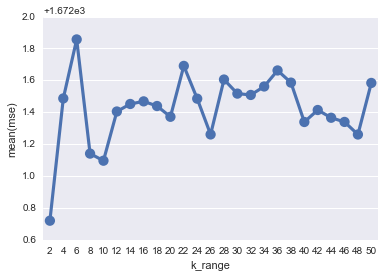

In [11]:
# code here
results = []
for i in range(2,51,2):
    kf = cross_validation.KFold(len(modeldata), n_folds=i, shuffle=True)
    scores = []
    for train_index, test_index in kf:
        train_X = modeldata.iloc[train_index]
        train_y = y.iloc[train_index]
        test_X = modeldata.iloc[test_index]
        test_y = y.iloc[test_index]
        lm = linear_model.LinearRegression().fit(train_X, train_y)
        test_predictions = lm.predict(test_X)
        scores.append(metrics.mean_squared_error(test_y, test_predictions))
    results.append(np.mean(scores))
sns.pointplot(x="k_range", y="mse", data=pd.DataFrame({'k_range': range(2,51,2), 'mse': results}))

In [12]:
results

[1672.719808585827,
 1673.4867263163255,
 1673.856791898949,
 1673.1406535828814,
 1673.0961418771633,
 1673.4047301085882,
 1673.4519702303553,
 1673.4683050390322,
 1673.4391194912382,
 1673.3715973799608,
 1673.6907748328499,
 1673.4852197064629,
 1673.2608470078719,
 1673.6052375448162,
 1673.5169640944266,
 1673.5085811915437,
 1673.5616957732318,
 1673.6622128537495,
 1673.5859811524683,
 1673.338928092465,
 1673.4140854333466,
 1673.3655754376764,
 1673.3393112341585,
 1673.2604756696528,
 1673.5838949009778]

Shuffle = True takes random slices from the index; False takes the slices in order.

MSE seems to converge around 1673.4 after kfold = 10.

## Slide: "Where regularisation makes sense"

In [13]:
# Evaluate MSE for whole model using LinearRegression (no regularisation), then regularised regression
lm = linear_model.LinearRegression().fit(modeldata, y)
lasso_lm = linear_model.Lasso().fit(modeldata, y)
ridge_lm = linear_model.Ridge().fit(modeldata, y)

# These scores will be worse (i.e. higher error) - we're now trading off bias error for generalised error
print "MSE for simple linear regression:", metrics.mean_squared_error(y, lm.predict(modeldata))
print "MSE for Lasso regression:", metrics.mean_squared_error(y, lasso_lm.predict(modeldata))
print "MSE for Ridge regression:", metrics.mean_squared_error(y, ridge_lm.predict(modeldata))

MSE for simple linear regression: 1672.58110765
MSE for Lasso regression: 1725.41581608
MSE for Ridge regression: 1672.60490113


## Slide: Understanding regularisation effects

[  1.00000000e-10   1.00000000e-09   1.00000000e-08   1.00000000e-07
   1.00000000e-06   1.00000000e-05   1.00000000e-04   1.00000000e-03
   1.00000000e-02   1.00000000e-01   1.00000000e+00   1.00000000e+01
   1.00000000e+02   1.00000000e+03   1.00000000e+04   1.00000000e+05
   1.00000000e+06   1.00000000e+07   1.00000000e+08   1.00000000e+09
   1.00000000e+10]
Axes(0.125,0.125;0.775x0.775)


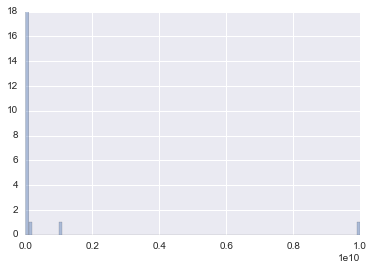

In [14]:
# Let's test a variety of alpha weights for Ridge Regression on the bikeshare data
alphas = np.logspace(start=-10, stop=10, num=21)
# Returns numbers between start & stop spaced evenly on a log scale
# http://docs.scipy.org/doc/numpy-1.10.0/reference/generated/numpy.logspace.html
# More: http://stackoverflow.com/questions/31480033/difference-in-output-between-numpy-linspace-and-numpy-logspace
print alphas  # See what the logspace() function outputs
print sns.distplot(alphas, hist=True, kde=False, bins=100)

In [15]:
# For each alpha, fit Ridge regression model to data, print MSE
for a in alphas:
    print 'Alpha:', a
    lm = linear_model.Ridge(alpha=a)
    lm.fit(modeldata, y)
    print lm.coef_
    print metrics.mean_squared_error(y, lm.predict(modeldata))
    print

Alpha: 1e-10
[ 112.68901765  -84.01121684  -24.68489063  -21.00314493  -21.71893628]
1672.58110765

Alpha: 1e-09
[ 112.68901765  -84.01121684  -24.68489061  -21.00314491  -21.71893626]
1672.58110765

Alpha: 1e-08
[ 112.68901765  -84.01121684  -24.6848904   -21.00314471  -21.71893606]
1672.58110765

Alpha: 1e-07
[ 112.68901763  -84.01121682  -24.68488837  -21.00314268  -21.71893403]
1672.58110765

Alpha: 1e-06
[ 112.68901745  -84.01121667  -24.68486804  -21.00312237  -21.71891373]
1672.58110765

Alpha: 1e-05
[ 112.68901562  -84.01121509  -24.68466472  -21.00291929  -21.71871079]
1672.58110765

Alpha: 0.0001
[ 112.68899732  -84.01119938  -24.68263174  -21.00088873  -21.71668162]
1672.58110765

Alpha: 0.001
[ 112.68881437  -84.01104228  -24.66232204  -20.98060316  -21.69640993]
1672.58110774

Alpha: 0.01
[ 112.68698753  -84.00947323  -24.46121539  -20.77973778  -21.49568404]
1672.58111645

Alpha: 0.1
[ 112.66896732  -83.99396383  -22.63109556  -18.95202277  -19.66942371]
1672.58185208

Al

## Slide: "We can make this easier with grid search!"

In [17]:
from sklearn import grid_search

alphas = np.logspace(-10, 10, 21)
gs = grid_search.GridSearchCV(
    estimator=linear_model.Ridge(),
    param_grid={'alpha': alphas},
    scoring='mean_squared_error')

gs.fit(modeldata, y)

print "Best score"
print -gs.best_score_     # Mean Squared Error here comes in negative, so let's make it positive
print
print "Best estimator"
print gs.best_estimator_  # Explains which grid_search setup worked best
print
print "All grid pairings & performances"
print gs.grid_scores_     # Shows all the grid pairings and their performances

# N.B. MSE lower than above as we're doing 3-fold CV by default!

Best score
1814.09369133

Best estimator
Ridge(alpha=10.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

All grid pairings & performances
[mean: -1817.58711, std: 542.14315, params: {'alpha': 1e-10}, mean: -1817.58711, std: 542.14315, params: {'alpha': 1.0000000000000001e-09}, mean: -1817.58711, std: 542.14315, params: {'alpha': 1e-08}, mean: -1817.58711, std: 542.14315, params: {'alpha': 9.9999999999999995e-08}, mean: -1817.58711, std: 542.14315, params: {'alpha': 9.9999999999999995e-07}, mean: -1817.58711, std: 542.14317, params: {'alpha': 1.0000000000000001e-05}, mean: -1817.58707, std: 542.14331, params: {'alpha': 0.0001}, mean: -1817.58663, std: 542.14477, params: {'alpha': 0.001}, mean: -1817.58230, std: 542.15933, params: {'alpha': 0.01}, mean: -1817.54318, std: 542.30102, params: {'alpha': 0.10000000000000001}, mean: -1817.20111, std: 543.63587, params: {'alpha': 1.0}, mean: -1814.09369, std: 556.35563, params:

## Activity: Grid search & cross-validation
Directions:
1. Modify the previous code to do the following:
  - Introduce cross validation into the grid search.  This is accessible from the cv argument.
  - Add fit_intercept = True and False to the param_grid dictionary.

2. Re-investigate the best score, best estimator, and grid score attributes as a result of the grid search.

In [32]:
# code here
alphas = np.logspace(-10, 10, 21)
crossvals = 10

gs = grid_search.GridSearchCV(
    estimator=linear_model.Ridge(),
    param_grid={'alpha': alphas,'fit_intercept':[True,False]},
    scoring='mean_squared_error',
    cv = cross_validation.KFold(n=len(modeldata),n_folds=crossvals,shuffle=True))

gs.fit(modeldata, y)

print "Best score"
print -gs.best_score_     # Mean Squared Error here comes in negative, so let's make it positive
print
print "Best estimator"
print gs.best_estimator_  # Explains which grid_search setup worked best
print
print "All grid pairings & performances"
print gs.grid_scores_     # Shows all the grid pairings and their performances

Best score
1673.89803568

Best estimator
Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

All grid pairings & performances
[mean: -1673.89805, std: 168.82163, params: {'alpha': 1e-10, 'fit_intercept': True}, mean: -1674.41598, std: 168.91265, params: {'alpha': 1e-10, 'fit_intercept': False}, mean: -1673.89805, std: 168.82163, params: {'alpha': 1.0000000000000001e-09, 'fit_intercept': True}, mean: -1674.41598, std: 168.91265, params: {'alpha': 1.0000000000000001e-09, 'fit_intercept': False}, mean: -1673.89805, std: 168.82163, params: {'alpha': 1e-08, 'fit_intercept': True}, mean: -1674.41598, std: 168.91265, params: {'alpha': 1e-08, 'fit_intercept': False}, mean: -1673.89805, std: 168.82163, params: {'alpha': 9.9999999999999995e-08, 'fit_intercept': True}, mean: -1674.41598, std: 168.91265, params: {'alpha': 9.9999999999999995e-08, 'fit_intercept': False}, mean: -1673.89805, std: 168.82163, params: {'alph

## Slide: "Gradient Descent"

In [26]:
# Simple example of gradient descent
# Problem: Get as close as you can to a given number by taking small pre-defined steps
num_to_approach = 6.2
start = 0.0
steps = [0.3, 0.5, 1]
optimised = False
max_iterations = 100
iteration = 0
while not optimised and iteration < max_iterations:
    current_distance = num_to_approach - start  # initially this would be 6.2
    got_better = False  # just initialising the var for now...
    next_steps = [start + i for i in steps]  # e.g. from 0.0 this creates [-1, 1]
    for n in next_steps:
        distance = np.abs(num_to_approach - n)  # e.g. from [-1, 1] this creates [7.2, 5.2]
        if distance < current_distance:  # if we're now a little closer...
            got_better = True
            current_distance = distance
            start = n
    if got_better:
        print 'Iteration {0}: Found better solution using {1} (distance = {2})'.format(iteration, start, current_distance)
        iteration += 1
    else:
        optimized = True
        print "\nDone! {0} is closest to {1} ({2} iterations)".format(start, num_to_approach, iteration)
        break

# See how it performs using different step sizes, e.g. [-0.3, 0.5, 1]
# Try changing num_to_approach to np.pi and playing around with steps, random start points, max iterations, etc

Iteration 0: Found better solution using 1.0 (distance = 5.2)
Iteration 1: Found better solution using 2.0 (distance = 4.2)
Iteration 2: Found better solution using 3.0 (distance = 3.2)
Iteration 3: Found better solution using 4.0 (distance = 2.2)
Iteration 4: Found better solution using 5.0 (distance = 1.2)
Iteration 5: Found better solution using 6.0 (distance = 0.2)
Iteration 6: Found better solution using 6.3 (distance = 0.1)

Done! 6.3 is closest to 6.2 (7 iterations)


## Slide: "Application of gradient descent"

In [27]:
# We can easily run a gradient descent regression
lm = linear_model.SGDRegressor()
lm.fit(modeldata, y)
print "R-Squared:", lm.score(modeldata, y)
print "MSE:", metrics.mean_squared_error(y, lm.predict(modeldata))

R-Squared: 0.30840222284
MSE: 1681.1677876


## Homework Activity: "On your own"

Use the following code to work through the problems given. This code shows a few of the challenges and some of the gotchas of using these techniques. The plots will help showcase some of these.

_"There are tons of ways to approach a regression problem."_

Directions:
1. Implement the Gradient Descent approach to our bikeshare modelling problem.
2. Show how Gradient Descent solves and optimises the solution.
3. Demonstrate the grid_search module.
4. Use a model you evaluated last class or the simpler one from today. Implement param_grid in grid search to answer the following questions:
  - With a set of alpha values between 10^-10 and 10^-1, how does the mean squared error change?
  - Our data suggests we use L1 regularisation.  By using a grid search with l1_ratios between 0 and 1 (increasing every 0.05), does this statement hold true? If it doesn't look like it does, do we know if gradient descent had enough iterations to work properly? 
  - How do these results change when you alter the learning rate (power_t)?

In [ ]:
# Starter code
params = {} # put your gradient descent parameters here
gs = grid_search.GridSearchCV(
    estimator=linear_model.SGDRegressor(),
    cv=cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True),
    param_grid=params,
    scoring='mean_squared_error',
    )

gs.fit(modeldata, y)

print 'BEST ESTIMATOR'
print -gs.best_score_
print gs.best_estimator_
print 'ALL ESTIMATORS'
print gs.grid_scores_

1. Implement the Gradient Descent approach to our bikeshare modelling problem.

In [39]:
alphas = np.logspace(-10, 10, 21)
crossvals = 5

params = {'alpha':alphas}
gs = grid_search.GridSearchCV(
    estimator=linear_model.SGDRegressor(),
    cv=cross_validation.KFold(len(modeldata), n_folds=crossvals, shuffle=True),
    param_grid=params,
    scoring='mean_squared_error',
    )

gs.fit(modeldata, y)

print 'BEST ESTIMATOR'
print -gs.best_score_
print gs.best_estimator_
print 'ALL ESTIMATORS'
print gs.grid_scores_

BEST ESTIMATOR
1688.98471046
SGDRegressor(alpha=1.0000000000000001e-09, average=False, epsilon=0.1,
       eta0=0.01, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', n_iter=5,
       penalty='l2', power_t=0.25, random_state=None, shuffle=True,
       verbose=0, warm_start=False)
ALL ESTIMATORS
[mean: -1690.38532, std: 124.39620, params: {'alpha': 1e-10}, mean: -1688.98471, std: 122.02951, params: {'alpha': 1.0000000000000001e-09}, mean: -1693.05697, std: 124.48255, params: {'alpha': 1e-08}, mean: -1691.82589, std: 122.54842, params: {'alpha': 9.9999999999999995e-08}, mean: -1690.82303, std: 124.00229, params: {'alpha': 9.9999999999999995e-07}, mean: -1690.13937, std: 123.59181, params: {'alpha': 1.0000000000000001e-05}, mean: -1689.60908, std: 123.91770, params: {'alpha': 0.0001}, mean: -1692.86799, std: 124.14688, params: {'alpha': 0.001}, mean: -1730.53176, std: 132.15255, params: {'alpha': 0.01}, mean: -2055.08845, std: 156.22262, params: {

In [40]:
# Save all output data (alphas vs MSE) into a new dataframe
grid = pd.DataFrame(gs.grid_scores_)
grid.columns = ['alpha', 'mean_squared_error', 'cv']
grid['alpha'] = grid['alpha'].apply(lambda x: x['alpha'])  # currently contains a dict, e.g. {u'alpha': 1e-10}
grid['mean_squared_error'] = grid['mean_squared_error'].apply(lambda x: -x)  # currently negative, e.g. -1688.707934
grid

,alpha,mean_squared_error,cv
0,1.000000e-10,1690.385317,"[-1825.7963674, -1621.49982613, -1487.50515313..."
1,1.000000e-09,1688.984710,"[-1817.46654669, -1622.02572803, -1488.7129687..."
2,1.000000e-08,1693.056966,"[-1828.52304522, -1628.04709787, -1488.5346307..."
3,1.000000e-07,1691.825890,"[-1823.11222176, -1628.0862235, -1489.23328099..."
4,1.000000e-06,1690.823028,"[-1823.26984695, -1623.56366145, -1487.5544558..."
5,1.000000e-05,1690.139367,"[-1823.67739316, -1622.18436354, -1488.1935565..."
6,1.000000e-04,1689.609084,"[-1819.20380213, -1621.22158706, -1486.6223877..."
7,1.000000e-03,1692.867986,"[-1825.22803233, -1625.12037652, -1489.1056013..."
8,1.000000e-02,1730.531759,"[-1883.77722899, -1649.50264956, -1520.6194821..."
9,1.000000e-01,2055.088450,"[-2256.79253322, -1940.47239929, -1822.6665621..."


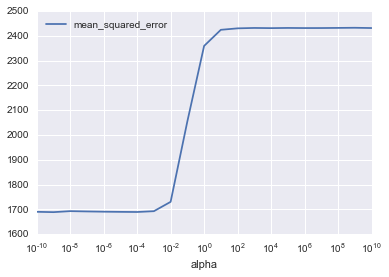

In [42]:
grid.plot('alpha', 'mean_squared_error', logx=True)

In [43]:
alpha = 0.001
l1_l2_ratios = np.linspace(0, 1, 21)
params = {
    'l1_ratio': l1_l2_ratios,
    'penalty': ['elasticnet'],
    'alpha': [alpha],
    'n_iter': [50]
}
crossvals = 5

gs = grid_search.GridSearchCV(
    estimator=linear_model.SGDRegressor(),
    cv=cross_validation.KFold(len(modeldata), n_folds=crossvals, shuffle=True),
    param_grid=params,
    scoring='mean_squared_error',
    )

gs.fit(modeldata, y)
grid = pd.DataFrame(gs.grid_scores_)
grid.columns = ['l1_ratio', 'mean_squared_error', 'cv']
grid['l1_ratio'] = grid['l1_ratio'].apply(lambda x: x['l1_ratio'])
grid['mean_squared_error'] = grid['mean_squared_error'].apply(lambda x: -x)
grid

,l1_ratio,mean_squared_error,cv
0,0.00,1674.463542,"[-1647.45719084, -1728.42975961, -1734.7360780..."
1,0.05,1674.204280,"[-1648.60098506, -1727.96093343, -1734.6504817..."
2,0.10,1674.392424,"[-1647.58538198, -1726.60508402, -1737.5348280..."
3,0.15,1673.811864,"[-1647.82844216, -1726.71701191, -1734.9742501..."
4,0.20,1674.846322,"[-1648.03381896, -1727.06756099, -1734.6733790..."
5,0.25,1674.137655,"[-1646.98243006, -1727.31532709, -1734.6697987..."
6,0.30,1674.596398,"[-1647.61099987, -1726.82036183, -1734.7003885..."
7,0.35,1675.316311,"[-1648.76771266, -1732.97598933, -1735.1804485..."
8,0.40,1674.919690,"[-1646.80535327, -1733.42381018, -1734.8548253..."
9,0.45,1674.317218,"[-1646.69249392, -1730.35720706, -1734.1036032..."


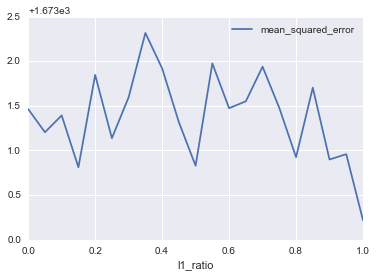

In [44]:
grid.plot('l1_ratio', 'mean_squared_error')

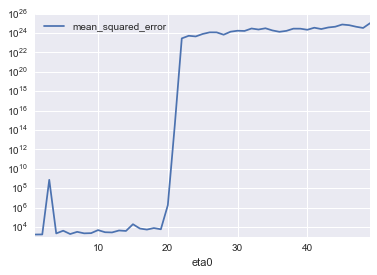

In [46]:
learning = range(1, 50)
params = {
    'eta0':learning,
    'n_iter': [50]
}
gs = grid_search.GridSearchCV(
    estimator=linear_model.SGDRegressor(),
    cv=cross_validation.KFold(len(modeldata), n_folds=5, shuffle=True),
    param_grid=params,
    scoring='mean_squared_error',
    )
gs.fit(modeldata, y)
grid = pd.DataFrame(gs.grid_scores_)
grid.columns = ['eta0', 'mean_squared_error', 'cv']
grid['eta0'] = grid['eta0'].apply(lambda x: x['eta0'])
grid['mean_squared_error'] = grid['mean_squared_error'].apply(lambda x: -x)
grid.plot('eta0', 'mean_squared_error', logy=True)